In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [5]:
learning_rate = 0.001
num_steps = 30000
batch_size = 64

image_dim = 784
hidden_dim = 512
latent_dim = 2

def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [6]:
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [8]:
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                      name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [10]:
def vae_loss(x_reconstructed, x_true):
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                        + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    k1_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    k1_div_loss = -0.5 * tf.reduce_sum(k1_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + k1_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

init = tf.global_variables_initializer()

In [13]:
sess = tf.Session()

sess.run(init)

for i in range(1, num_steps+1):
    
    batch_x, _ = mnist.train.next_batch(batch_size)
    
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i,1))

Step 1, Loss: 1.000000
Step 1000, Loss: 1.000000
Step 2000, Loss: 1.000000
Step 3000, Loss: 1.000000
Step 4000, Loss: 1.000000
Step 5000, Loss: 1.000000
Step 6000, Loss: 1.000000
Step 7000, Loss: 1.000000
Step 8000, Loss: 1.000000
Step 9000, Loss: 1.000000
Step 10000, Loss: 1.000000
Step 11000, Loss: 1.000000
Step 12000, Loss: 1.000000
Step 13000, Loss: 1.000000
Step 14000, Loss: 1.000000
Step 15000, Loss: 1.000000
Step 16000, Loss: 1.000000
Step 17000, Loss: 1.000000
Step 18000, Loss: 1.000000
Step 19000, Loss: 1.000000
Step 20000, Loss: 1.000000
Step 21000, Loss: 1.000000
Step 22000, Loss: 1.000000
Step 23000, Loss: 1.000000
Step 24000, Loss: 1.000000
Step 25000, Loss: 1.000000
Step 26000, Loss: 1.000000
Step 27000, Loss: 1.000000
Step 28000, Loss: 1.000000
Step 29000, Loss: 1.000000
Step 30000, Loss: 1.000000


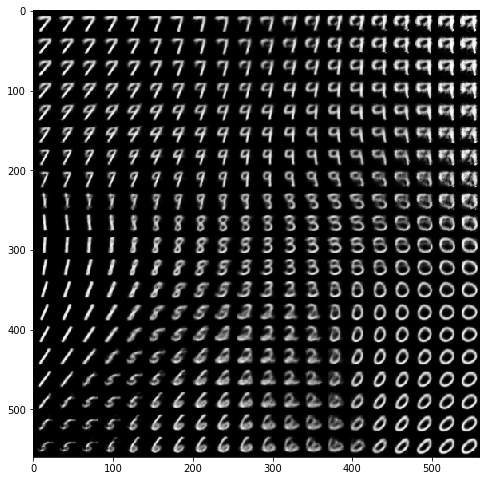

In [17]:
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])

decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
            x_mean[0].reshape(28, 28)
        
plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()